In [1]:
import os
import scipy.io as sio

# 切换到包含文件的目录
os.chdir('/Users/gengxingri/Desktop/Leetcodes/HUAWEI/data')

from decimal import Decimal
import numpy as np

from scipy.sparse import csc_matrix,  identity
from scipy.sparse.linalg import eigsh, norm, spsolve, cg, minres
import scipy.sparse as sp
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time



In [2]:
# 读取.mat 文件
data = sio.loadmat('BenElechi1.mat')


A = data['Problem']['A'][0][0]
print(A.shape, type(A))

b = data['Problem']['b'][0][0]
print(b.shape, type(b))



(245874, 245874) <class 'scipy.sparse._csc.csc_matrix'>
(245874, 40543) <class 'scipy.sparse._csc.csc_matrix'>


In [3]:
column = b.getcol(0)
b = column.tocsc() 
print(b.shape, type(b))

(245874, 1) <class 'scipy.sparse._csc.csc_matrix'>


In [4]:
'''
eigval_min 的值可以通过参数 tol 优化
'''

# Calculate the condition number
start_time = time.time()

# return eigenvalues that have the min and max abs values, respectively
eigval_max = eigsh(A, k=1, which='LM', return_eigenvectors=False)[0]
eigval_min = eigsh(A, k=1, which='SM', return_eigenvectors=False, tol=5)[0] # the result is vary rough
print(eigval_min, eigval_max)

condition_number = eigval_max / eigval_min

print("Condition number based on eigenvalues:", condition_number)

end_time = time.time()
execution_time = end_time - start_time

print(f"Runing time：{execution_time} s")

4.232053202763398 1955.9988170535141
Condition number based on eigenvalues: 462.18672671135334
Runing time：2.3304920196533203 s


In [5]:
# Create the diagonal preconditioner
n = A.shape[0]
diag_A = A.diagonal()

D = csc_matrix((1 / np.sqrt(diag_A), (np.arange(n), np.arange(n))), shape=(n, n))

# Apply preconditioning
A_new = D.dot(A.dot(D))
b_new = D.dot(b) / norm(D.dot(b))

print(A_new.diagonal(), norm(b_new))


[1. 1. 1. ... 1. 1. 1.] 1.0000000000000002


In [6]:
'''
eigval_min 的值可以通过参数 tol 优化
'''
# Calculate the condition number

eigval_max = eigsh(A_new, k=1, which='LM', return_eigenvectors=False)[0]
eigval_min = eigsh(A_new, k=1, which='SM', return_eigenvectors=False,tol=5)[0]
print(eigval_min, eigval_max)

precond_cond = eigval_max / eigval_min

print("Condition number based on eigenvalues:", precond_cond)


0.009800930097118365 4.2799356050168225
Condition number based on eigenvalues: 436.68667795877803


In [7]:
# Unique solution of Ax = b

x_unique = spsolve(A_new, b_new)
print(x_unique)

[ 5.85593557e-01  7.38985583e-01  6.65360134e-01 ...  2.05860855e-03
  1.40801047e-04 -7.11791884e-05]


In [8]:
# CG mtheod

def conjugate_gradient_sparse(A, b, tol=1e-8, max_iter=35000):
    n = b.shape[0] 
    x = np.zeros(n).reshape((n,1))
    r = b - A @ x
    #print(r.shape, type(r))
    xk_cg =[]
    
    
    p = r.copy()
    r_norm_sq = np.dot(r.T,r)
    errors = []  # Initial error
    #print(x.shape, r_norm_sq.shape)

    for i in range(max_iter):
        i += 1
        Ap = A @ p
        alpha = r_norm_sq / np.dot(p.T, Ap)
        x = x + alpha * p
        r -= alpha * Ap
        
        r_norm_sq_new = np.dot(r.T, r)
        
        # Append new error
        if i%500 == 0:
            errors.append(np.sqrt(r_norm_sq_new)) 
            xk_cg.append(x)
            
        if np.sqrt(r_norm_sq_new) < tol:
            print(f"Converged after {i+1} iterations")
            return x, errors, xk_cg
        
        beta = r_norm_sq_new / r_norm_sq
        p = r + beta * p
        r_norm_sq = r_norm_sq_new
    
    print(f"Did not converge after {max_iter} iterations")
    return x, errors, xk_cg

# Solve using our CG implementation
start_time = time.time()

b_array = b_new.toarray()
x_cg, errors, xk = conjugate_gradient_sparse(A_new, b_array)

cg_time = time.time() - start_time

print(f"CG method took {cg_time:.4f} seconds")

# change the type of errors_cg and xk_cg
errors_cg = [arr[0][0] for arr in errors]
xk_cg = [np.reshape(arr,-1) for arr in xk]


print(len(xk_cg))
print('\n',errors_cg[0:5])

Converged after 32397 iterations
CG method took 736.0430 seconds
64

 [0.0009019161198258465, 0.0005051372385020586, 0.00039783265756186724, 0.0003117560743003572, 0.00030033836448450614]


In [12]:
# MINRES method

errors_minres = []
xk_minres = []

iteration_count = 0

def callback(xk):
    global iteration_count
    iteration_count += 1
    
    if iteration_count % 500 == 0:
        rk = b_array - A_new.dot(xk).reshape(-1, 1)
        error_norm = np.linalg.norm(rk)
        errors_minres.append(error_norm)
        xk_minres.append(xk)
        
        
    if iteration_count % 500 == 0:
        return error_norm
    else:
        return None

x_minres, info_minres = minres(A_new, b_array, tol=1e-12, callback=callback)
print(x_minres, info_minres)
print(len(errors_minres))

[ 5.84288518e-01  7.37098248e-01  6.64242342e-01 ...  1.96589612e-03
  1.34890511e-04 -7.28336326e-05] 0
62


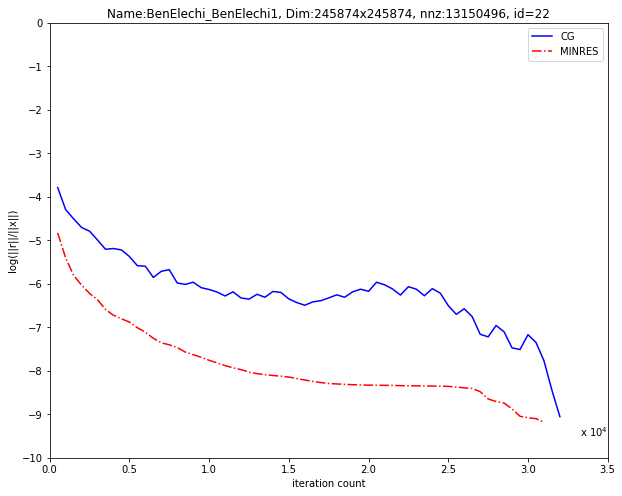

In [13]:
# Plot the log(||r||/||x||) errors

def plot_log(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1,len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.text(1, 0.06, 'x $10^4$', transform=ax.transAxes, ha='right', va='center')
    
    ax.set_ylabel('log(||r||/||x||)')
    ax.set_title('Name:BenElechi_BenElechi1, Dim:245874x245874, nnz:13150496, id=22')

    # Set x-axis limits
    ax.set_xlim(0, 70)
    ax.set_xticks(np.arange(0, 71, 10))
    ax.set_xticklabels([f'{i/20}' for i in np.arange(0, 71, 10)])
    
    ax.set_ylim(-10, 0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    
    
xk_cg_norms =  np.array([np.linalg.norm(xk) for xk in xk_cg])
xk_minres_norms =  np.array([np.linalg.norm(xk) for xk in xk_minres])

cg_errors_norm1 = np.log10(errors_cg / xk_cg_norms) 
minres_errors_norm1 = np.log10(errors_minres / xk_minres_norms)


# plot the graph
plot_log(cg_errors_norm1, minres_errors_norm1)

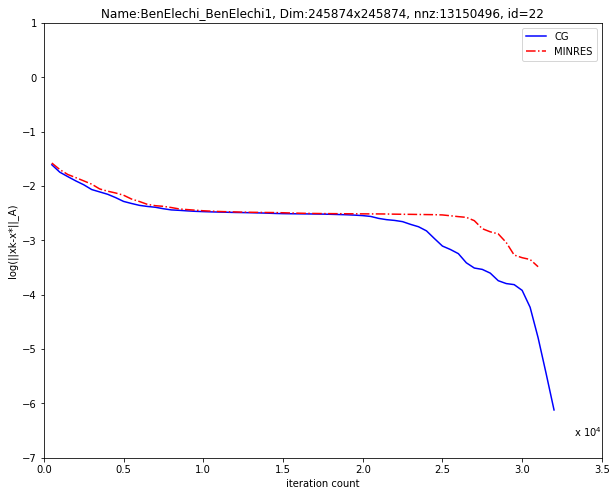

In [14]:
# Plot the log(||xk-x*||_A) errors

def plot_A_norm(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1,len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

     # Set labels and title
    ax.set_xlabel('iteration count')
    ax.text(1, 0.06, 'x $10^4$', transform=ax.transAxes, ha='right', va='center')
    
    ax.set_ylabel('log(||xk-x*||_A)')
    ax.set_title('Name:BenElechi_BenElechi1, Dim:245874x245874, nnz:13150496, id=22')

    # Set y-axis limits
    ax.set_xlim(0, 70)
    ax.set_xticks(np.arange(0, 71, 10))
    ax.set_xticklabels([f'{i/20}' for i in np.arange(0, 71, 10)])
    
    ax.set_ylim(-7, 1)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

# errors of log||xk - x* ||_A in each iteration
errors_iter_cg = [np.sqrt((xk - x_unique).T.dot(A_new.dot(xk - x_unique))) for xk in xk_cg]
xk_A_norms_cg = [np.array(err) for err in errors_iter_cg]
cg_errors_A_norm = np.log10(xk_A_norms_cg)


# errors of minres
errors_iter_minres = [np.sqrt((xk - x_unique).T.dot(A_new.dot(xk - x_unique))) for xk in xk_minres] # list of array
xk_A_norms_minres = [np.array(err) for err in errors_iter_minres]
minres_errors_A_norm = np.log10(xk_A_norms_minres)


# plot
plot_A_norm(cg_errors_A_norm, minres_errors_A_norm)

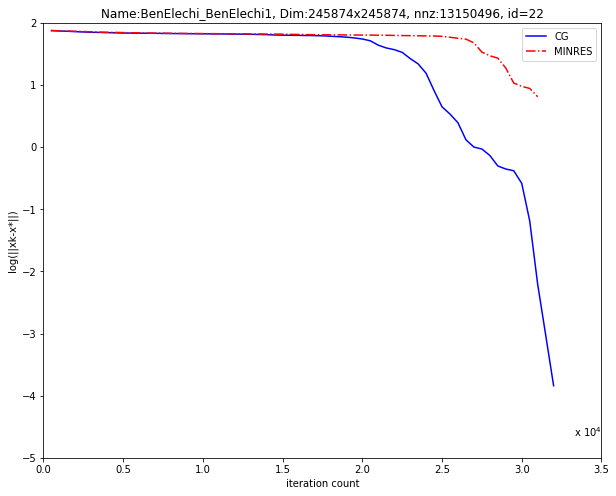

In [18]:
# Plot the log(||xk-x*||) errors

def plot_norm(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1, len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1, len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

      # Set labels and title
    ax.set_xlabel('iteration count')
    ax.text(1, 0.06, 'x $10^4$', transform=ax.transAxes, ha='right', va='center')
    
    ax.set_ylabel('log(||xk-x*||)')
    ax.set_title('Name:BenElechi_BenElechi1, Dim:245874x245874, nnz:13150496, id=22')

    # Set x-axis limits
    ax.set_xlim(0, 70)
    ax.set_xticks(np.arange(0, 71, 10))
    ax.set_xticklabels([f'{i/20}' for i in np.arange(0, 71, 10)])
    
    ax.set_ylim(-5, 2)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

# errors of log||xk - x* || in each iteration

# errors of cg
errors3_cg = [np.linalg.norm(xk - x_unique) for xk in xk_cg]
errors_norm3_cg = [np.array(err) for err in errors3_cg]


cg_errors_norm3 = np.log10(errors_norm3_cg)



# errors of minres

errors3_minres = [np.linalg.norm(xk - x_unique) for xk in xk_minres]
errors_norm3_minres = [np.array(err) for err in errors3_minres]


minres_errors_norm3 = np.log10(errors_norm3_minres)



# plot
plot_norm(cg_errors_norm3, minres_errors_norm3)

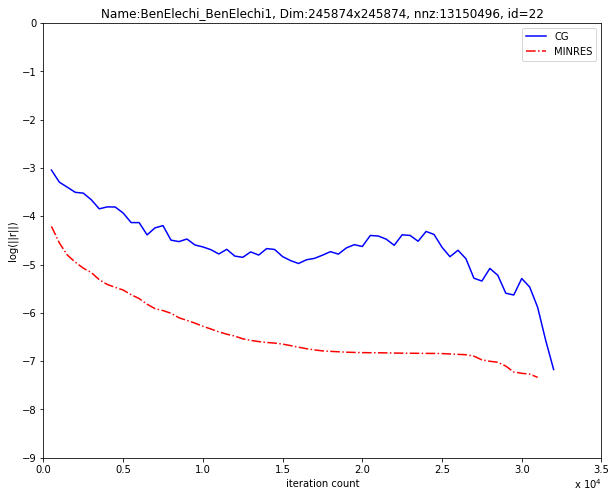

In [15]:
# Plot the log(||r||) errors

def plot_norm_4(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1, len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1, len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

     # Set labels and title
    ax.set_xlabel('iteration count')
    ax.text(1, -0.06, 'x $10^4$', transform=ax.transAxes, ha='right', va='center')
    
    ax.set_ylabel('log(||r||)')
    ax.set_title('Name:BenElechi_BenElechi1, Dim:245874x245874, nnz:13150496, id=22')

    # Set x-axis limits
    ax.set_xlim(0, 70)
    ax.set_xticks(np.arange(0, 71, 10))
    ax.set_xticklabels([f'{i/20}' for i in np.arange(0, 71, 10)])
    
    ax.set_ylim(-9, 0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

    
# errors of log||r|| in each iteration

# errors of cg
cg_errors_norm4 = np.log10(errors_cg)



# errors of minres
minres_errors_norm4 = np.log10(errors_minres)



# plot
plot_norm_4(cg_errors_norm4, minres_errors_norm4)

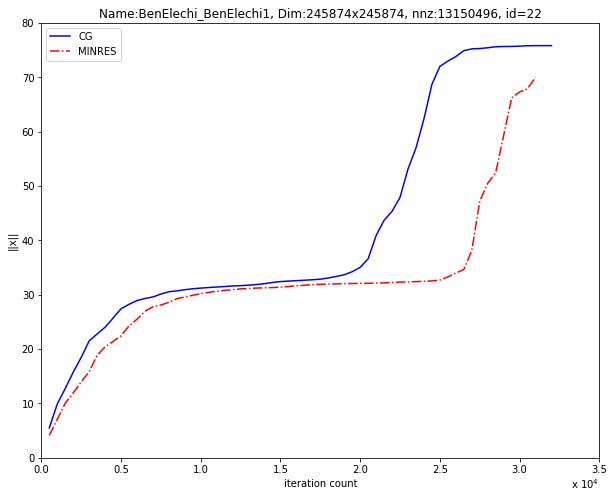

In [16]:
# Plot the ||x||

def plot_norm_5(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1,len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.text(1, -0.06, 'x $10^4$', transform=ax.transAxes, ha='right', va='center')
    
    ax.set_ylabel('||x||')
    ax.set_title('Name:BenElechi_BenElechi1, Dim:245874x245874, nnz:13150496, id=22')

    # Set y-axis limits
    ax.set_xlim(0, 70)
    ax.set_xticks(np.arange(0, 71, 10))
    ax.set_xticklabels([f'{i/20}' for i in np.arange(0, 71, 10)])
    
    ax.set_ylim(0, 80)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    
    
xk_cg_norm5 =  np.array([np.linalg.norm(xk) for xk in xk_cg])
xk_minres_norm5 =  np.array([np.linalg.norm(xk) for xk in xk_minres])

# plot
plot_norm_5(xk_cg_norm5, xk_minres_norm5)

In [50]:
# Now plot the indefinitesystem (A-\delta I)x = b, where\delta = 0.5

I = identity(n, format='csc')
A_indef = A_new - 0.5*I

# MINRES method

errors_indef_minres = []
xk_indef_minres = []

iteration_count_indef = 0

def callback2(xk):
    global iteration_count_indef
    iteration_count_indef += 1
    
    if iteration_count_indef % 1000 == 0:
        rk = b_array - A_indef.dot(xk).reshape(-1, 1)
        error_norm = np.linalg.norm(rk)
        
        errors_indef_minres.append(error_norm)
        xk_indef_minres.append(xk)
    
    if iteration_count_indef % 1000 == 0:
        return error_norm
    else:
        return None

x_indef_minres, info_indef_minres = minres(A_indef, b_array, tol=1e-8, callback=callback2)
print(x_indef_minres, info_indef_minres)

[-0.08601309  0.23113796  0.52135677 ...  0.00775101 -0.36918312
 -1.10994357] 0


In [51]:
len(errors_indef_minres), errors_indef_minres[0:5]

(158,
 [0.04354309699029636,
  0.03081399762540615,
  0.025201698623062055,
  0.021663403766508535,
  0.01931843070475445])

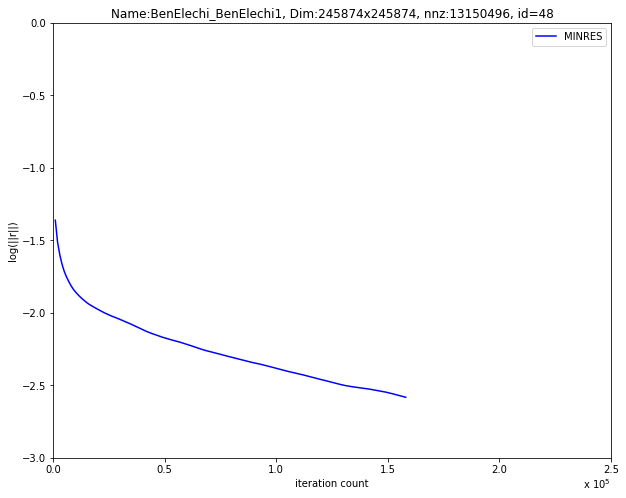

In [59]:
# Plot the log(||r||) errors

def plot_indef_log(minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'b-', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.text(1, -0.06, 'x $10^5$', transform=ax.transAxes, ha='right', va='center')
    
    ax.set_ylabel('log(||r||)')
    ax.set_title('Name:BenElechi_BenElechi1, Dim:245874x245874, nnz:13150496, id=48')

     # Set y-axis limits
    ax.set_xlim(0, 250)
    ax.set_xticks(np.arange(0, 251, 50))
    ax.set_xticklabels([f'{i/100}' for i in np.arange(0, 251, 50)])
    
    ax.set_ylim(-3, 0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    
    
errors_indef_minres =  np.array([np.linalg.norm(err) for err in errors_indef_minres])[:500]

minres_errors_indef = np.log10(errors_indef_minres)

# plot
plot_indef_log(minres_errors_indef)

In [56]:
len(xk_indef_minres), xk_indef_minres[0:5]

(158,
 [array([-3.97471920e-01,  9.86118333e-01,  2.25915148e-01, ...,
         -1.74714818e-05,  8.36857400e-04, -4.34923032e-04]),
  array([-0.42512687,  0.99635526,  0.22470862, ..., -0.00192975,
          0.0108341 , -0.01415375]),
  array([-0.43465811,  1.0108616 ,  0.23249243, ..., -0.01270148,
          0.00937552, -0.0124189 ]),
  array([-0.4622452 ,  1.03154489,  0.24337928, ..., -0.01459455,
         -0.00710608, -0.01155822]),
  array([-0.48126965,  1.06563378,  0.24194349, ..., -0.01634183,
         -0.01529875, -0.01441315])])

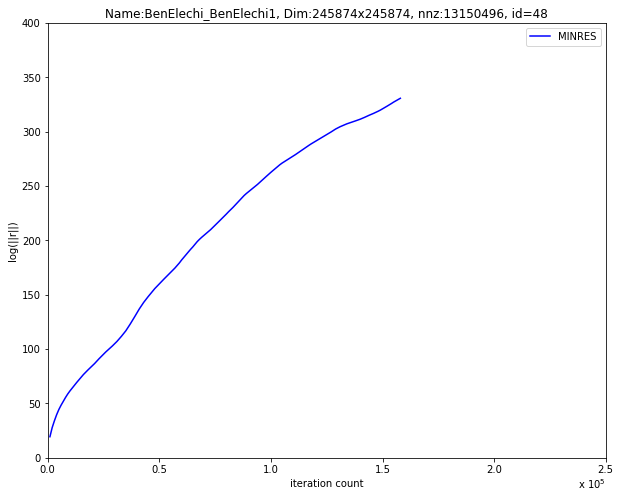

In [60]:
# Plot the ||x|| for the indefinite system

def plot_indef_norm(minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'b-', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.text(1, -0.06, 'x $10^5$', transform=ax.transAxes, ha='right', va='center')
    
    ax.set_ylabel('log(||r||)')
    ax.set_title('Name:BenElechi_BenElechi1, Dim:245874x245874, nnz:13150496, id=48')

     # Set x-axis limits
    ax.set_xlim(0, 250)
    ax.set_xticks(np.arange(0, 251, 50))
    ax.set_xticklabels([f'{i/100}' for i in np.arange(0, 251, 50)])
    
    ax.set_ylim(0, 400)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(50))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    

xk_minres_indef_norm =  np.array([np.linalg.norm(xk) for xk in xk_indef_minres])

# plot
plot_indef_norm(xk_minres_indef_norm)